- 心气虚：心、气虚、[痰、血瘀]
- 心血虚证：心、血虚
- 心阴虚：心、阴虚、[心神、痰、血瘀]
- 心阳虚：心、阳虚、[肾、寒、血瘀、气虚]
- 心血瘀阻：
- 心火亢盛：心、热、[血热、阴虚]
- 痰蒙心神证：心神、痰、闭、[经络、湿、气滞]
- 瘀阻脑络：心神、血瘀、[经络、气滞、闭、动风]

2022-10-14 11:19:43.144 | INFO     | __main__:<module>:71 - 使用 LASSO 进行特征选择,剩余(305, 45)个特征


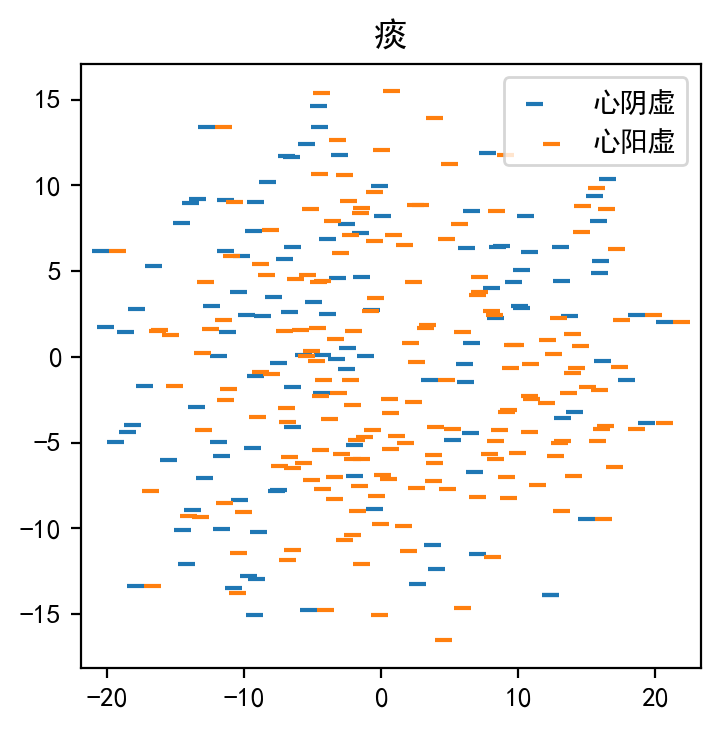

2022-10-14 11:19:44.096 | INFO     | __main__:<module>:106 - 使用 SMOTETomek 混合采样
2022-10-14 11:19:44.109 | INFO     | __main__:<module>:111 - 采样前：心阴虚有121条,心阳虚有184条
2022-10-14 11:19:44.109 | INFO     | __main__:<module>:112 - 采样后：心阴虚有177条,心阳虚有177条
2022-10-14 11:19:56.482 | INFO     | __main__:<module>:144 - {'max_depth': 9, 'grow_policy': 'depthwise', 'learning_rate': 0.3380273281801316, 'gamma': 1.2477751363527926e-06, 'reg_lambda': 2.2534652473878417e-08, 'reg_alpha': 0.0004492557852927738, 'subsample': 0.9793419120611897, 'colsample_bytree': 0.45368926673828647}
2022-10-14 11:19:56.757 | WARNING  | __main__:<module>:151 - {'fit_time': array([0.08399868, 0.07800007, 0.08353543]), 'score_time': array([0.00800085, 0.00699902, 0.00650692]), 'test_accuracy': array([0.76271186, 0.70338983, 0.72881356]), 'test_precision': array([0.78181818, 0.71428571, 0.73684211]), 'test_recall': array([0.72881356, 0.6779661 , 0.71186441]), 'test_f1': array([0.75438596, 0.69565217, 0.72413793])}
2022-10-14 

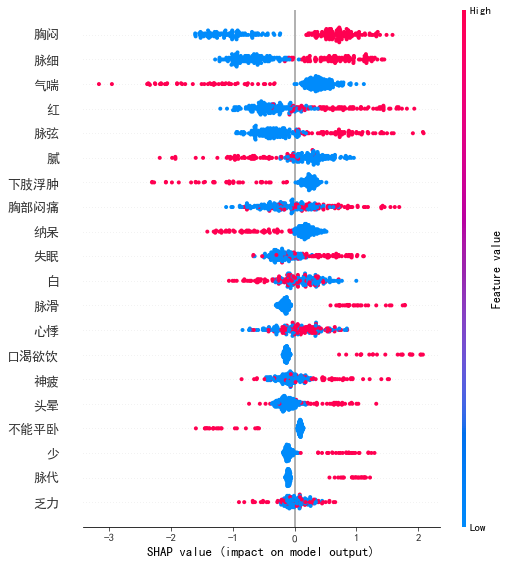

2022-10-14 11:19:57.438 | WARNING  | __main__:<module>:165 - 0.703	0.714	0.678	0.696


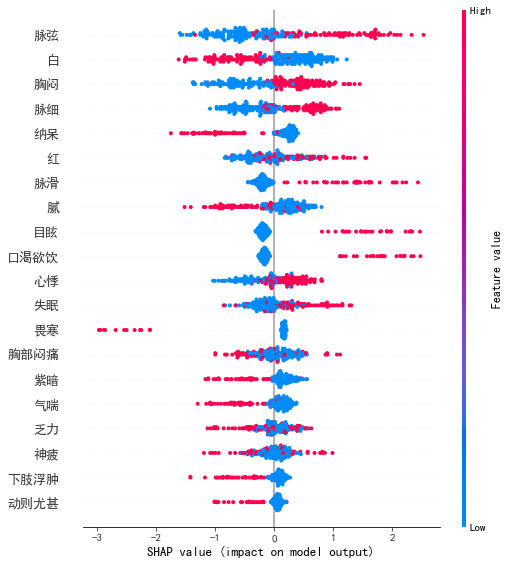

2022-10-14 11:19:58.030 | WARNING  | __main__:<module>:165 - 0.729	0.737	0.712	0.724


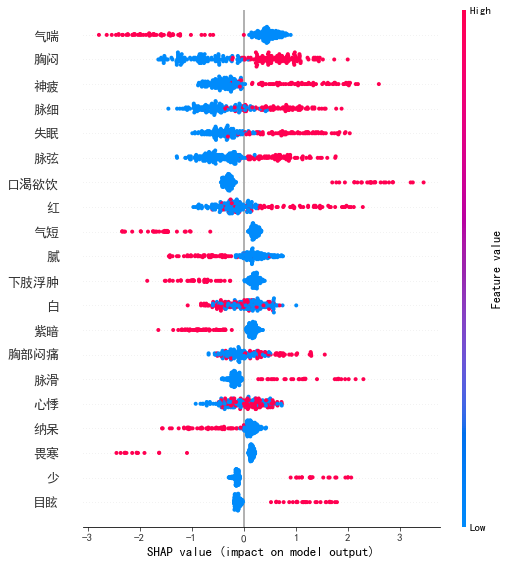

2022-10-14 11:19:58.524 | WARNING  | __main__:<module>:171 - accuracy		mean:0.732	std:0.024
2022-10-14 11:19:58.525 | WARNING  | __main__:<module>:173 - precision		mean:0.744	std:0.028
2022-10-14 11:19:58.526 | WARNING  | __main__:<module>:175 - recall		mean:0.706	std:0.021
2022-10-14 11:19:58.527 | WARNING  | __main__:<module>:177 - f1		mean:0.725	std:0.024


In [11]:
# 证素 - 痰
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = {0: '心阴虚', 1: '心阳虚'}
zhenghou2id = readJSON('./input/zhenghou2id.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
# sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
data = pd.read_csv('./output/xinbing-zhengsu.csv')
X = data.drop(columns=['证名','心','阳虚','肾','寒','血瘀','气虚','阴虚','心神','痰'])
# print(id2feature.values())
X.columns = readJSON('./input/id2feature.json').values()
y = data['痰']
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel

    # scaler = StandardScaler()
    # X_scale = scaler.fit_transform(X, y)
    # X_scale = pd.DataFrame(X, columns=scaler.n_features_in_)
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []

#TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(id2feature[i]))
plt.legend()
plt.title('痰')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(f'采样前：{id2feature[0]}有{Counter(y)[0]}条,{id2feature[1]}有{Counter(y)[1]}条')
logger.info(f'采样后：{id2feature[0]}有{Counter(y_resampled)[0]}条,{id2feature[1]}有{Counter(y_resampled)[1]}条')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')



2022-10-14 19:08:05.420 | INFO     | __main__:<module>:67 - 使用 LASSO 进行特征选择,剩余(305, 45)个特征


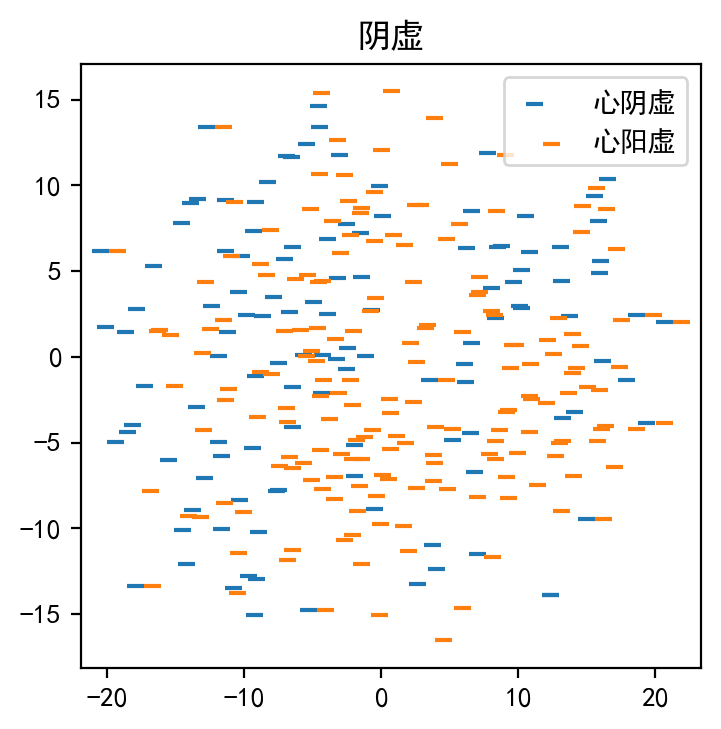

2022-10-14 19:08:06.357 | INFO     | __main__:<module>:102 - 使用 SMOTETomek 混合采样
2022-10-14 19:08:06.370 | INFO     | __main__:<module>:107 - 采样前：心阴虚有121条,心阳虚有184条
2022-10-14 19:08:06.371 | INFO     | __main__:<module>:108 - 采样后：心阴虚有177条,心阳虚有177条
2022-10-14 19:08:17.960 | INFO     | __main__:<module>:140 - {'max_depth': 6, 'grow_policy': 'depthwise', 'learning_rate': 0.03871176195485925, 'gamma': 8.895993855495118e-08, 'reg_lambda': 0.0044251858811258735, 'reg_alpha': 1.87660635867294e-06, 'subsample': 0.758985519044724, 'colsample_bytree': 0.7486735718907593}
2022-10-14 19:08:18.239 | WARNING  | __main__:<module>:147 - {'fit_time': array([0.08599949, 0.08310723, 0.08200121]), 'score_time': array([0.00700045, 0.00699782, 0.00699925]), 'test_accuracy': array([0.76271186, 0.69491525, 0.69491525]), 'test_precision': array([0.78181818, 0.71698113, 0.68852459]), 'test_recall': array([0.72881356, 0.6440678 , 0.71186441]), 'test_f1': array([0.75438596, 0.67857143, 0.7       ])}
2022-10-14 19:0

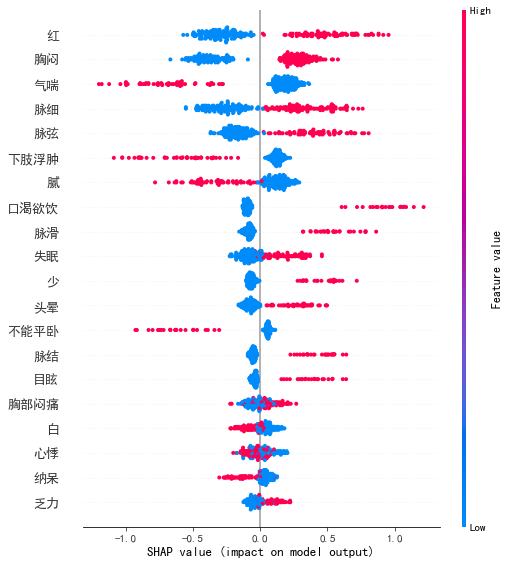

2022-10-14 19:08:18.912 | WARNING  | __main__:<module>:161 - 0.695	0.717	0.644	0.679


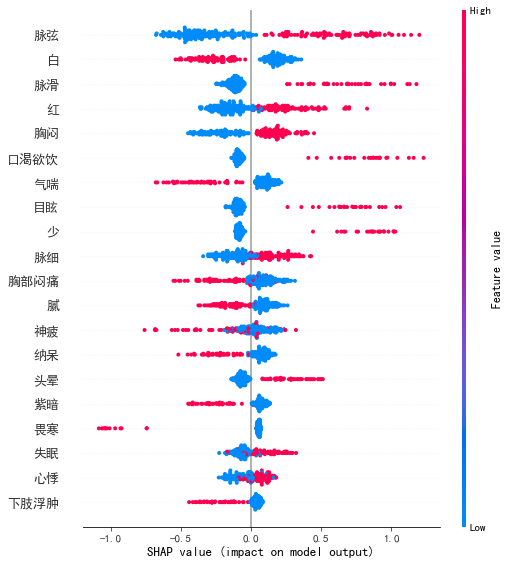

2022-10-14 19:08:19.469 | WARNING  | __main__:<module>:161 - 0.695	0.689	0.712	0.7


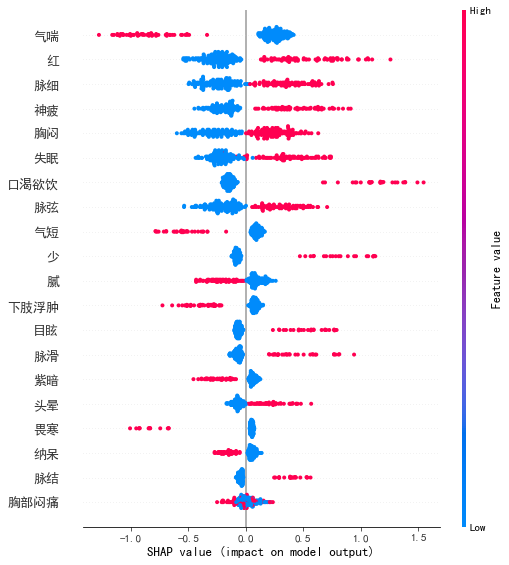

2022-10-14 19:08:19.943 | WARNING  | __main__:<module>:167 - accuracy		mean:0.718	std:0.032
2022-10-14 19:08:19.943 | WARNING  | __main__:<module>:169 - precision		mean:0.729	std:0.039
2022-10-14 19:08:19.944 | WARNING  | __main__:<module>:171 - recall		mean:0.695	std:0.037
2022-10-14 19:08:19.944 | WARNING  | __main__:<module>:173 - f1		mean:0.711	std:0.032


In [2]:
# 证素 - 阴虚
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = {0: '心阴虚', 1: '心阳虚'}
zhenghou2id = readJSON('./input/zhenghou2id.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
# sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
data = pd.read_csv('./output/xinbing-zhengsu.csv')
X = data.drop(columns=['证名','心','阳虚','肾','寒','血瘀','气虚','阴虚','心神','痰'])

X.columns = readJSON('./input/id2feature.json').values()
y = data['阴虚']
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []

#TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(id2feature[i]))
plt.legend()
plt.title('阴虚')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(f'采样前：{id2feature[0]}有{Counter(y)[0]}条,{id2feature[1]}有{Counter(y)[1]}条')
logger.info(f'采样后：{id2feature[0]}有{Counter(y_resampled)[0]}条,{id2feature[1]}有{Counter(y_resampled)[1]}条')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')


2022-10-14 19:09:07.041 | INFO     | __main__:<module>:67 - 使用 LASSO 进行特征选择,剩余(305, 45)个特征


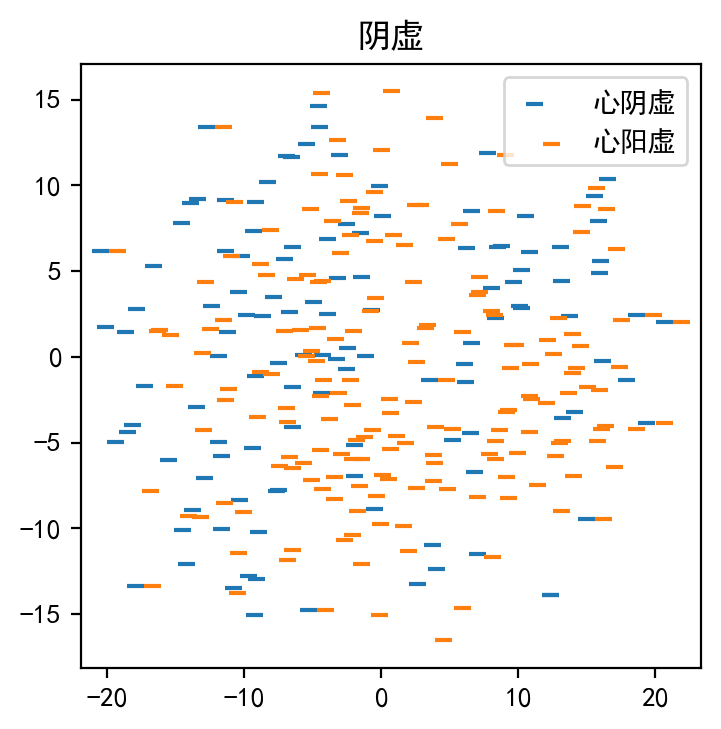

2022-10-14 19:09:07.955 | INFO     | __main__:<module>:102 - 使用 SMOTETomek 混合采样
2022-10-14 19:09:07.967 | INFO     | __main__:<module>:107 - 采样前：心阴虚有121条,心阳虚有184条
2022-10-14 19:09:07.968 | INFO     | __main__:<module>:108 - 采样后：心阴虚有177条,心阳虚有177条
2022-10-14 19:09:19.379 | INFO     | __main__:<module>:140 - {'max_depth': 6, 'grow_policy': 'lossguide', 'learning_rate': 0.031497508163306216, 'gamma': 0.0030403708465317598, 'reg_lambda': 0.00013308690176204346, 'reg_alpha': 3.5323202411030573e-06, 'subsample': 0.6898160412606328, 'colsample_bytree': 0.7395079196597749}
2022-10-14 19:09:19.663 | WARNING  | __main__:<module>:147 - {'fit_time': array([0.08700037, 0.0839994 , 0.08499861]), 'score_time': array([0.00800157, 0.00799966, 0.00699973]), 'test_accuracy': array([0.77118644, 0.71186441, 0.69491525]), 'test_precision': array([0.7962963 , 0.73584906, 0.68852459]), 'test_recall': array([0.72881356, 0.66101695, 0.71186441]), 'test_f1': array([0.76106195, 0.69642857, 0.7       ])}
2022-10-14

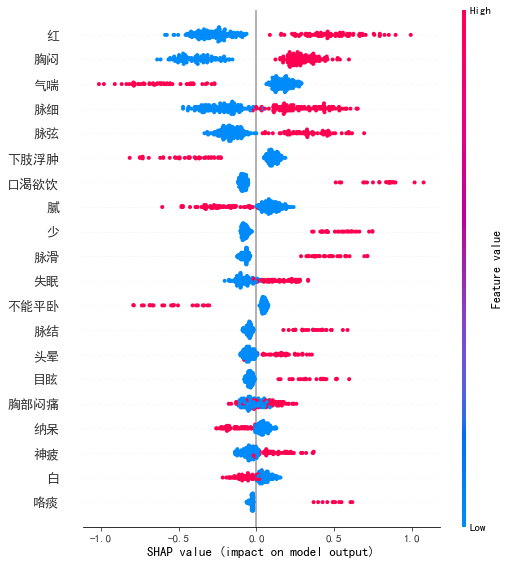

2022-10-14 19:09:20.425 | WARNING  | __main__:<module>:161 - 0.712	0.736	0.661	0.696


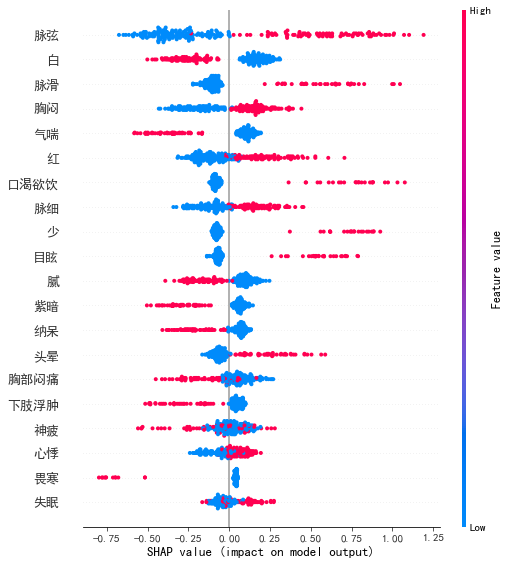

2022-10-14 19:09:21.001 | WARNING  | __main__:<module>:161 - 0.695	0.689	0.712	0.7


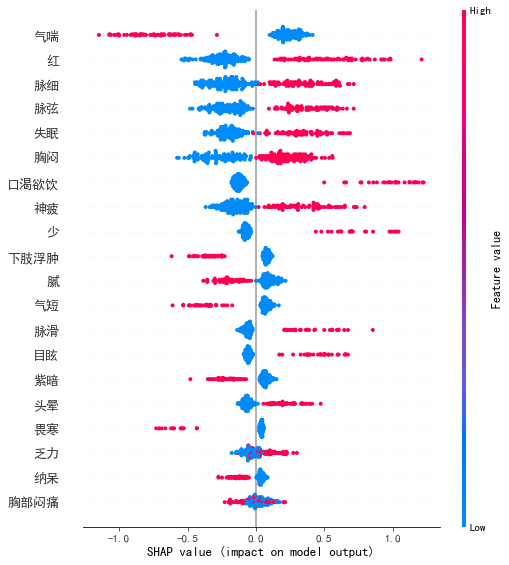

2022-10-14 19:09:21.482 | WARNING  | __main__:<module>:167 - accuracy		mean:0.726	std:0.033
2022-10-14 19:09:21.483 | WARNING  | __main__:<module>:169 - precision		mean:0.74	std:0.044
2022-10-14 19:09:21.484 | WARNING  | __main__:<module>:171 - recall		mean:0.701	std:0.029
2022-10-14 19:09:21.485 | WARNING  | __main__:<module>:173 - f1		mean:0.719	std:0.03


In [3]:
# 证素 - 阴虚
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = {0: '心阴虚', 1: '心阳虚'}
zhenghou2id = readJSON('./input/zhenghou2id.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
# sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
data = pd.read_csv('./output/xinbing-zhengsu.csv')
X = data.drop(columns=['证名','心','阳虚','肾','寒','血瘀','气虚','阴虚','心神','痰'])

X.columns = readJSON('./input/id2feature.json').values()
y = data['心神']
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []

#TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(id2feature[i]))
plt.legend()
plt.title('阴虚')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(f'采样前：{id2feature[0]}有{Counter(y)[0]}条,{id2feature[1]}有{Counter(y)[1]}条')
logger.info(f'采样后：{id2feature[0]}有{Counter(y_resampled)[0]}条,{id2feature[1]}有{Counter(y_resampled)[1]}条')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')


2022-10-14 19:09:46.021 | INFO     | __main__:<module>:67 - 使用 LASSO 进行特征选择,剩余(305, 45)个特征


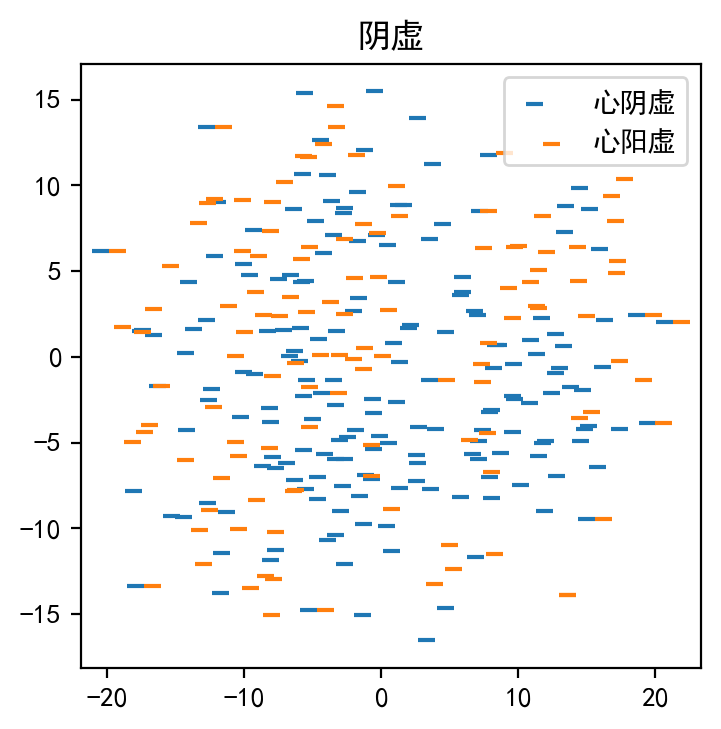

2022-10-14 19:09:46.943 | INFO     | __main__:<module>:102 - 使用 SMOTETomek 混合采样
2022-10-14 19:09:46.955 | INFO     | __main__:<module>:107 - 采样前：心阴虚有184条,心阳虚有121条
2022-10-14 19:09:46.955 | INFO     | __main__:<module>:108 - 采样后：心阴虚有177条,心阳虚有177条
2022-10-14 19:09:59.026 | INFO     | __main__:<module>:140 - {'max_depth': 12, 'grow_policy': 'depthwise', 'learning_rate': 0.15436033403034172, 'gamma': 1.7598980468054998e-07, 'reg_lambda': 3.8022127517752426e-06, 'reg_alpha': 0.0003854712781787198, 'subsample': 0.8619590429700147, 'colsample_bytree': 0.5728157347373667}
2022-10-14 19:09:59.312 | WARNING  | __main__:<module>:147 - {'fit_time': array([0.09000087, 0.08599854, 0.08299971]), 'score_time': array([0.00700068, 0.00799894, 0.0070014 ]), 'test_accuracy': array([0.73728814, 0.70338983, 0.71186441]), 'test_precision': array([0.71875   , 0.6875    , 0.71929825]), 'test_recall': array([0.77966102, 0.74576271, 0.69491525]), 'test_f1': array([0.74796748, 0.71544715, 0.70689655])}
2022-10-14

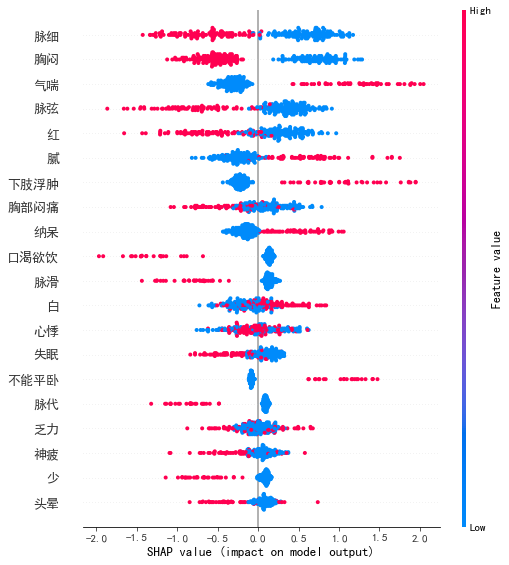

2022-10-14 19:10:00.010 | WARNING  | __main__:<module>:161 - 0.703	0.688	0.746	0.715


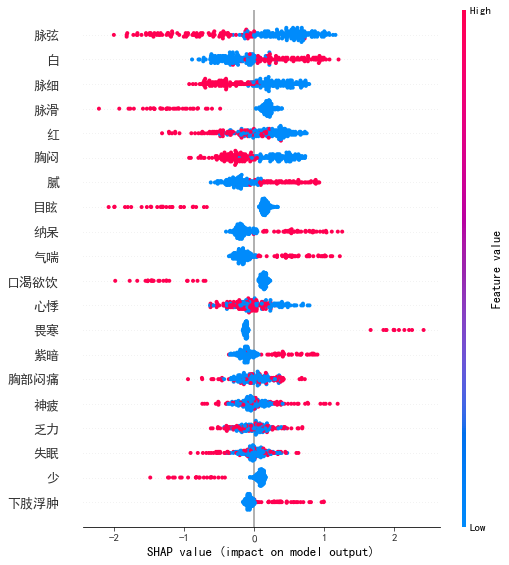

2022-10-14 19:10:00.585 | WARNING  | __main__:<module>:161 - 0.712	0.719	0.695	0.707


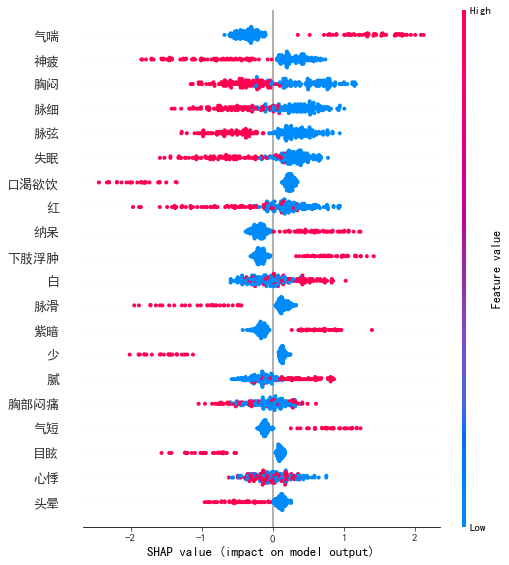

2022-10-14 19:10:01.056 | WARNING  | __main__:<module>:167 - accuracy		mean:0.718	std:0.014
2022-10-14 19:10:01.056 | WARNING  | __main__:<module>:169 - precision		mean:0.709	std:0.015
2022-10-14 19:10:01.057 | WARNING  | __main__:<module>:171 - recall		mean:0.74	std:0.035
2022-10-14 19:10:01.058 | WARNING  | __main__:<module>:173 - f1		mean:0.723	std:0.018


In [4]:
# 证素 - 阴虚
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = {0: '心阴虚', 1: '心阳虚'}
zhenghou2id = readJSON('./input/zhenghou2id.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
# sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
data = pd.read_csv('./output/xinbing-zhengsu.csv')
X = data.drop(columns=['证名','心','阳虚','肾','寒','血瘀','气虚','阴虚','心神','痰'])

X.columns = readJSON('./input/id2feature.json').values()
y = data['阳虚']
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []

#TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(id2feature[i]))
plt.legend()
plt.title('阴虚')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(f'采样前：{id2feature[0]}有{Counter(y)[0]}条,{id2feature[1]}有{Counter(y)[1]}条')
logger.info(f'采样后：{id2feature[0]}有{Counter(y_resampled)[0]}条,{id2feature[1]}有{Counter(y_resampled)[1]}条')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')


2022-10-14 19:10:41.443 | INFO     | __main__:<module>:67 - 使用 LASSO 进行特征选择,剩余(305, 45)个特征


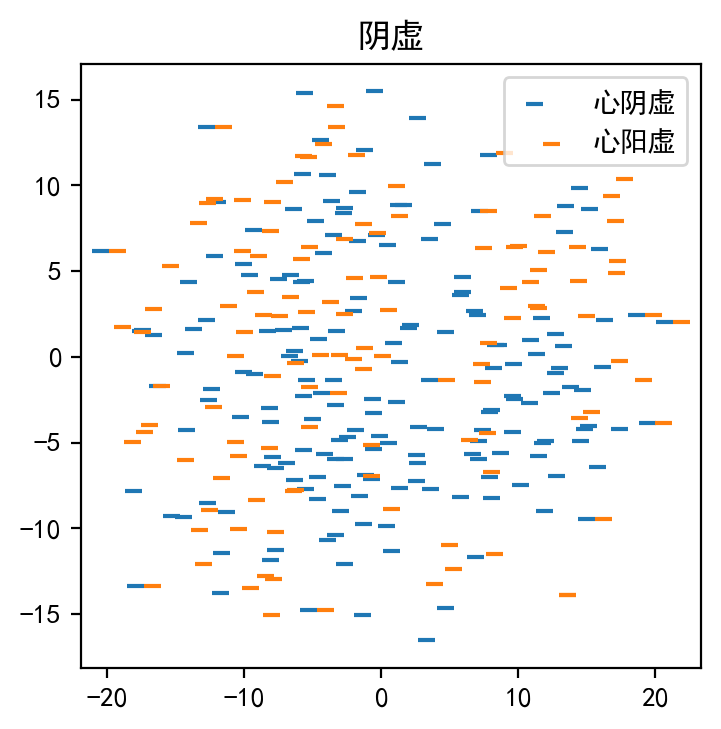

2022-10-14 19:10:42.442 | INFO     | __main__:<module>:102 - 使用 SMOTETomek 混合采样
2022-10-14 19:10:42.452 | INFO     | __main__:<module>:107 - 采样前：心阴虚有184条,心阳虚有121条
2022-10-14 19:10:42.453 | INFO     | __main__:<module>:108 - 采样后：心阴虚有177条,心阳虚有177条
2022-10-14 19:10:54.255 | INFO     | __main__:<module>:140 - {'max_depth': 9, 'grow_policy': 'lossguide', 'learning_rate': 0.1534788353531897, 'gamma': 0.0002741842286017545, 'reg_lambda': 1.8731226262467304e-06, 'reg_alpha': 5.843600407508616e-07, 'subsample': 0.5788595187737445, 'colsample_bytree': 0.7307456958278638}
2022-10-14 19:10:54.536 | WARNING  | __main__:<module>:147 - {'fit_time': array([0.09000015, 0.08500147, 0.08000064]), 'score_time': array([0.00699949, 0.00699854, 0.00699973]), 'test_accuracy': array([0.72881356, 0.6779661 , 0.68644068]), 'test_precision': array([0.70769231, 0.66153846, 0.69642857]), 'test_recall': array([0.77966102, 0.72881356, 0.66101695]), 'test_f1': array([0.74193548, 0.69354839, 0.67826087])}
2022-10-14 19

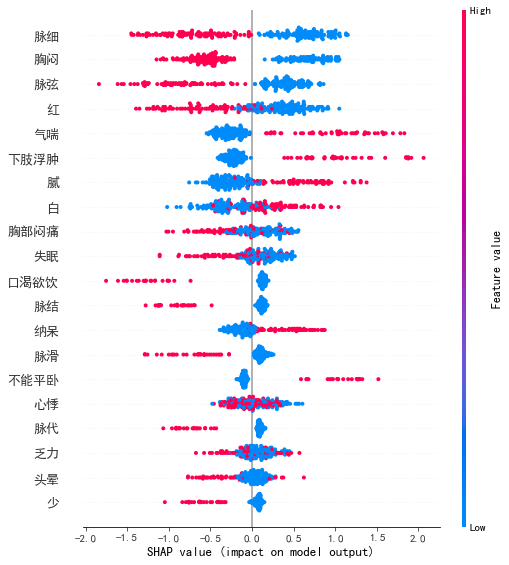

2022-10-14 19:10:55.292 | WARNING  | __main__:<module>:161 - 0.678	0.662	0.729	0.694


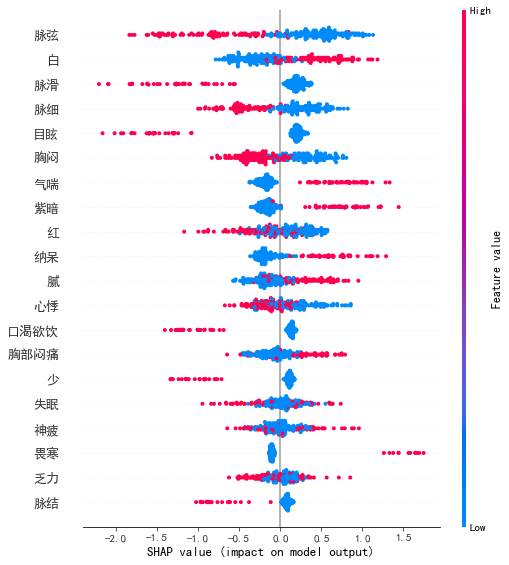

2022-10-14 19:10:55.852 | WARNING  | __main__:<module>:161 - 0.686	0.696	0.661	0.678


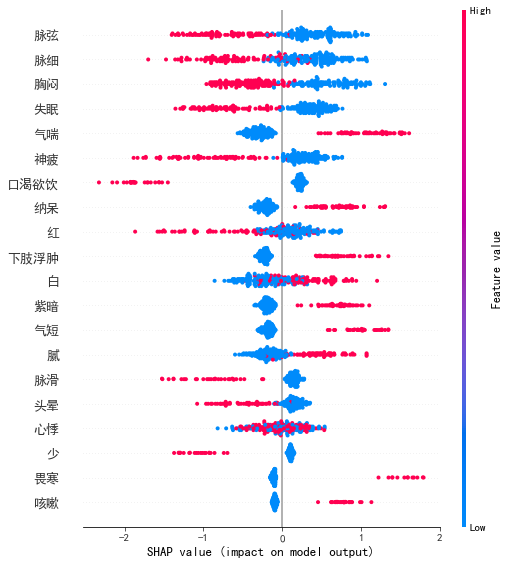

2022-10-14 19:10:56.311 | WARNING  | __main__:<module>:167 - accuracy		mean:0.698	std:0.022
2022-10-14 19:10:56.313 | WARNING  | __main__:<module>:169 - precision		mean:0.689	std:0.02
2022-10-14 19:10:56.313 | WARNING  | __main__:<module>:171 - recall		mean:0.723	std:0.049
2022-10-14 19:10:56.314 | WARNING  | __main__:<module>:173 - f1		mean:0.705	std:0.027


In [5]:
# 证素 - 阴虚
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = {0: '心阴虚', 1: '心阳虚'}
zhenghou2id = readJSON('./input/zhenghou2id.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
# sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
data = pd.read_csv('./output/xinbing-zhengsu.csv')
X = data.drop(columns=['证名','心','阳虚','肾','寒','血瘀','气虚','阴虚','心神','痰'])

X.columns = readJSON('./input/id2feature.json').values()
y = data['肾']
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []

#TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(id2feature[i]))
plt.legend()
plt.title('阴虚')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(f'采样前：{id2feature[0]}有{Counter(y)[0]}条,{id2feature[1]}有{Counter(y)[1]}条')
logger.info(f'采样后：{id2feature[0]}有{Counter(y_resampled)[0]}条,{id2feature[1]}有{Counter(y_resampled)[1]}条')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')


2022-10-14 19:12:38.752 | INFO     | __main__:<module>:67 - 使用 LASSO 进行特征选择,剩余(305, 45)个特征


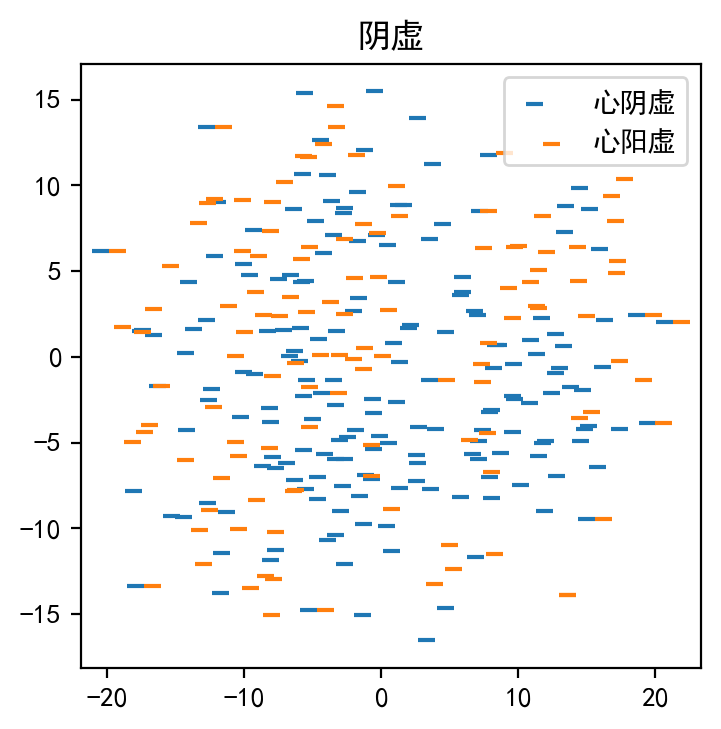

2022-10-14 19:12:39.680 | INFO     | __main__:<module>:102 - 使用 SMOTETomek 混合采样
2022-10-14 19:12:39.691 | INFO     | __main__:<module>:107 - 采样前：心阴虚有184条,心阳虚有121条
2022-10-14 19:12:39.692 | INFO     | __main__:<module>:108 - 采样后：心阴虚有177条,心阳虚有177条
2022-10-14 19:12:51.793 | INFO     | __main__:<module>:140 - {'max_depth': 8, 'grow_policy': 'depthwise', 'learning_rate': 0.02835671026163952, 'gamma': 1.2777320615413543e-08, 'reg_lambda': 4.289392971993468e-07, 'reg_alpha': 1.0395566331121042e-07, 'subsample': 0.664038474826137, 'colsample_bytree': 0.6686664857035226}
2022-10-14 19:12:52.087 | WARNING  | __main__:<module>:147 - {'fit_time': array([0.09163022, 0.09047008, 0.08328152]), 'score_time': array([0.00726891, 0.00694442, 0.00706768]), 'test_accuracy': array([0.76271186, 0.71186441, 0.68644068]), 'test_precision': array([0.74603175, 0.6984127 , 0.7037037 ]), 'test_recall': array([0.79661017, 0.74576271, 0.6440678 ]), 'test_f1': array([0.7704918 , 0.72131148, 0.67256637])}
2022-10-14 1

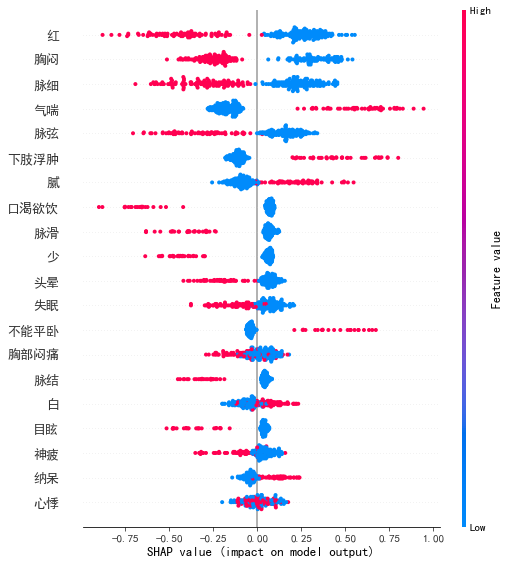

2022-10-14 19:12:52.784 | WARNING  | __main__:<module>:161 - 0.712	0.698	0.746	0.721


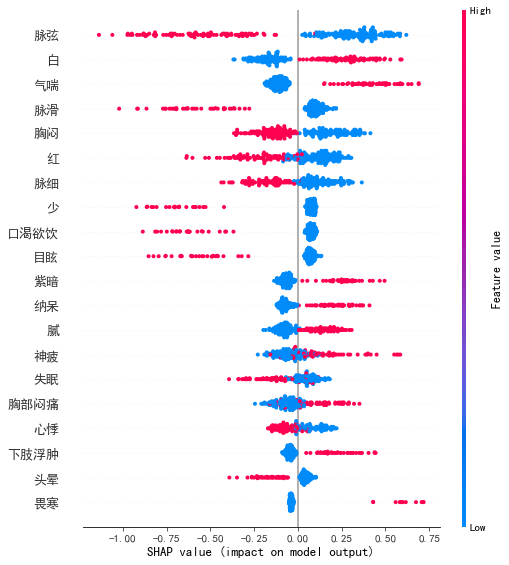

2022-10-14 19:12:53.378 | WARNING  | __main__:<module>:161 - 0.686	0.704	0.644	0.673


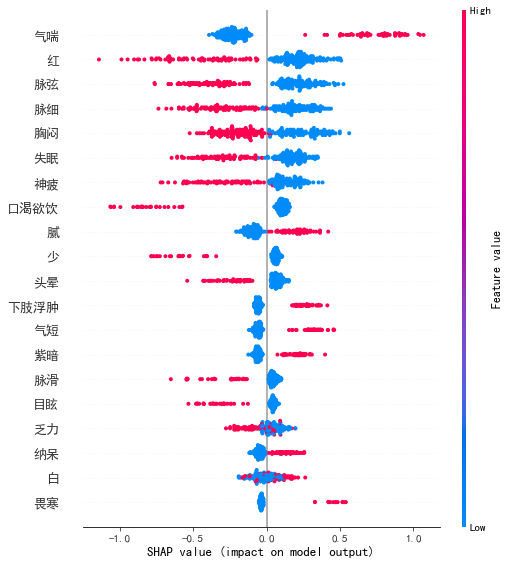

2022-10-14 19:12:53.863 | WARNING  | __main__:<module>:167 - accuracy		mean:0.72	std:0.032
2022-10-14 19:12:53.864 | WARNING  | __main__:<module>:169 - precision		mean:0.716	std:0.021
2022-10-14 19:12:53.865 | WARNING  | __main__:<module>:171 - recall		mean:0.729	std:0.063
2022-10-14 19:12:53.865 | WARNING  | __main__:<module>:173 - f1		mean:0.721	std:0.04


In [6]:
# 证素 - 阴虚
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2, SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from loguru import logger
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from utils import readJSON, preprocess
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import shap
import collections
from collections import Counter
from datetime import datetime
from pprint import pprint
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings

warnings.filterwarnings('ignore')

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
id2feature = {0: '心阴虚', 1: '心阳虚'}
zhenghou2id = readJSON('./input/zhenghou2id.json')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决无法显示符号的问题
# sns.set(font='SimHei', font_scale=0.8)  # 解决Seaborn中文显示问题
data = pd.read_csv('./output/xinbing-zhengsu.csv')
X = data.drop(columns=['证名','心','阳虚','肾','寒','血瘀','气虚','阴虚','心神','痰'])

X.columns = readJSON('./input/id2feature.json').values()
y = data['气虚']
USE_chi2, USE_f_classif, USE_mutual_info_classif, USE_LSVC = False, False, False, True
if USE_chi2:
    logger.info('使用 卡方检验 进行特诊筛选')
    chi2_model = SelectKBest(chi2, k=80)
    X = pd.DataFrame(chi2_model.fit_transform(
        X, y), columns=chi2_model.get_feature_names_out())
elif USE_f_classif:
    logger.info('使用 F检验 进行特征筛选')
    f_classif_model = SelectKBest(f_classif, k=80)
    X = pd.DataFrame(f_classif_model.fit_transform(
        X, y), columns=f_classif_model.get_feature_names_out())
elif USE_mutual_info_classif:
    logger.info('使用 互信息法 进行特征筛选')
    mutual_info_classif_model = SelectKBest(mutual_info_classif, k=80)
    X = pd.DataFrame(mutual_info_classif_model.fit_transform(X, y),
                     columns=mutual_info_classif_model.get_feature_names_out())
elif USE_LSVC:
    from sklearn.svm import LinearSVC
    from sklearn.feature_selection import SelectFromModel
    lsvc = LinearSVC(C=0.009, penalty='l2', dual=False,
                     random_state=64).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    # X_new = model.transform(X_ce)
    col = [c for c, i in zip(X.columns, model.get_support()) if not i]
    X.drop(columns=col, inplace=True)
    logger.info(f'使用 LASSO 进行特征选择,剩余{X.shape}个特征')
Accuracy = []
Precision = []
Recall = []
F1 = []

#TSNE
tsne = TSNE(n_components=2, init='pca', random_state=64)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(4, 4), dpi=200)
for i in range(0, 2):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1],
                cmap=plt.cm.Set1(i), marker=i, label=str(id2feature[i]))
plt.legend()
plt.title('阴虚')
plt.show()

# 数据平衡
USE_randomDownSample, USE_Tomek_links, USE_ADASYN, USE_randomOverSample, USE_SMOTE, USE_SMOTETomek = False, False, False, False, False, True
if USE_randomDownSample:
    logger.info('使用 randomDownSample 下采样')
    sampler = RandomUnderSampler(random_state=64)
elif USE_Tomek_links:
    logger.info('使用 TomekLinks 下采样')
    sampler = TomekLinks()
elif USE_ADASYN:
    logger.info('使用 ADASYN 上采样')
    sampler = ADASYN(random_state=64)
elif USE_randomOverSample:
    logger.info('使用 randomOverSample 上采样')
    sampler = RandomOverSampler(random_state=64)
elif USE_SMOTE:
    logger.info('使用 SMOTE 上采样')
    sampler = SMOTE(random_state=64)
elif USE_SMOTETomek:
    logger.info('使用 SMOTETomek 混合采样')
    sampler = SMOTETomek(random_state=64)
else:
    assert False, '没有平衡数据'
X_resampled, y_resampled = sampler.fit_resample(X, y)
logger.info(f'采样前：{id2feature[0]}有{Counter(y)[0]}条,{id2feature[1]}有{Counter(y)[1]}条')
logger.info(f'采样后：{id2feature[0]}有{Counter(y_resampled)[0]}条,{id2feature[1]}有{Counter(y_resampled)[1]}条')


def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=64)
    param = {
        'verbosity': 0,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        # 'n_estimators':trial.suggest_int('n_estimators',3500,3600),
        'max_depth': trial.suggest_int("max_depth", 3, 12, step=1),
        'grow_policy': trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        'tree_method': 'exact',
        # 'booster': 'dart',
        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        # 'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        'random_state': 42
    }
    model = xgb.XGBClassifier(**param).fit(train_x, train_y)
    preds = model.predict(valid_x)
    return accuracy_score(valid_y, preds)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
# logger.info(study.best_value)
logger.info(study.best_params)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=64)
modelcv = xgb.XGBClassifier(**study.best_params)
# modelcv.save_model(f'./output/model/{datetime.now()}.json')

cv = cross_validate(modelcv, X_resampled, y_resampled, scoring=[
    'accuracy', 'precision', 'recall', 'f1'], cv=kf)
logger.warning(cv)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    # print(Counter(y_resampled.loc[train_index]),Counter(y_resampled.loc[test_index]))
    model = xgb.XGBClassifier(**study.best_trial.params).fit(
        X_resampled.loc[train_index], y_resampled.loc[train_index])
    preds = model.predict(X_resampled.loc[test_index])
    accuracy = accuracy_score(y_resampled[test_index], preds)
    Accuracy.append(accuracy)
    precision = precision_score(y_resampled[test_index], preds)
    Precision.append(precision)
    recall = recall_score(y_resampled[test_index], preds)
    Recall.append(recall)
    f1 = f1_score(y_resampled[test_index], preds)
    F1.append(f1)
    logger.warning(f'{round(np.mean(accuracy), 3)}\t{round(np.mean(precision), 3)}\t'
                   f'{round(np.mean(recall), 3)}\t{round(np.mean(f1), 3)}')
    explainer = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainer.shap_values(
        X_resampled.loc[train_index])
    shap.summary_plot(shap_values_XGBoost_train, X_resampled.iloc[train_index])
logger.warning(
    f'accuracy\t\tmean:{round(np.mean(Accuracy), 3)}\tstd:{round(np.std(Accuracy), 3)}')
logger.warning(
    f'precision\t\tmean:{round(np.mean(Precision), 3)}\tstd:{round(np.std(Precision), 3)}')
logger.warning(
    f'recall\t\tmean:{round(np.mean(Recall), 3)}\tstd:{round(np.std(Recall), 3)}')
logger.warning(
    f'f1\t\tmean:{round(np.mean(F1), 3)}\tstd:{round(np.std(F1), 3)}')
